# Group C : Jing Wang,Vikash Bajiya, Deviprasad Saka  
# Classification Project : Histopathologic-cancer-detection

1. **Problem Statement**
    - Histopathologic cancer detection involves identifying metastatic cancer in small image patches extracted from larger pathology scans. Accurate detection aids in timely diagnosis and treatment planning.
2. **Objective**
    - To design and evaluate multiple machine learning models for binary image classification, leveraging advanced preprocessing, augmentation,and optimization techniques.
3. **Dataset**
    - The dataset consists of 32x32-pixel pathology images labeled as positive (cancerous) or negative (non-cancerous).
    - Dataset Link- https://www.kaggle.com/c/histopathologic-cancer-detection/data
  
###  Model Design and Implementation

Six models were designed, trained, and evaluated to identify the most effective classifier:

- **Naive Bayes**
- **Random Forest**
- **Logistic Regression**
- **Support Vector Machine (SVM)**
- **Neural Network**
- **XGBoost (Not covered in class)**


## 1. Data Processing

In [13]:
!pip install xgboost

In [15]:
# General purpose libraries
import os
import glob
import gc
import pickle
import random
import numpy as np
import pandas as pd

# Data Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Image handling
from PIL import Image
from torchvision import transforms

# Data preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Model evaluation and training
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc
)

# Machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

# Advanced techniques
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Deep learnibg libraries
import torch
import torch.nn as nn
import torch.optim as optim

# Saving and loading models
from joblib import dump, load

### 1.1 Data Cleaning

- Verified consistency between the dataset and the label file.
- Identified and removed missing, extra, or corrupted images.
- Ensured there were no duplicate images in the dataset.

In [17]:
# Define the main directory where all data for the project is stored
data_dir = "/Users/vikashbajiya/Downloads/histopathologic-cancer-detection"

# Define paths to the subdirectories and important files
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
train_labels_path = os.path.join(data_dir, "train_labels.csv")
sample_submission_path = os.path.join(data_dir, "sample_submission.csv")

# Load the training labels file into a pandas DataFrame
train_labels = pd.read_csv(train_labels_path)

# Check for missing values in the labels file
missing_values = train_labels.isnull().sum()
print("Missing values in train_labels.csv:")
print(missing_values)

# Get the list of image files in the training directory
train_files = set(os.listdir(train_dir))


# Get the list of image file names mentioned in the labels file
# Add ".tif" extension since the images are in TIFF format
train_labels_files = set(train_labels["id"] + ".tif")

# Find images mentioned in the labels file but missing in the training directory
missing_files = train_labels_files - train_files

# Find images that are in the training directory but not mentioned in the labels file
extra_files = train_files - train_labels_files

# Print the count of missing and extra files
print(f"Number of missing images: {len(missing_files)}")
print(f"Number of extra images: {len(extra_files)}")

# Function to check if image files are valid (not corrupted)
def check_image_validity(image_dir, file_set):
    invalid_images = []
    for file_name in file_set:
        file_path = os.path.join(image_dir, file_name)
        try:
            with Image.open(file_path) as img:
                img.verify()
        except (IOError, SyntaxError):
            invalid_images.append(file_name)
    return invalid_images

# Check for damaged or invalid image files in the training directory
invalid_train_images = check_image_validity(train_dir, train_files)

# Print the number of damaged image files found
print(f"Number of damaged training images: {len(invalid_train_images)}")

# Save the cleaned labels file to a new CSV file
# This file can later be used for training the model
train_labels.to_csv(os.path.join(data_dir, "cleaned_train_labels.csv"), index=False)

Missing values in train_labels.csv:
id       0
label    0
dtype: int64
Number of missing images: 0
Number of extra images: 1
Number of damaged training images: 1


### 1.2 Exploratory Data Analysis (EDA)

#### 1.2.1 Data Visualization

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


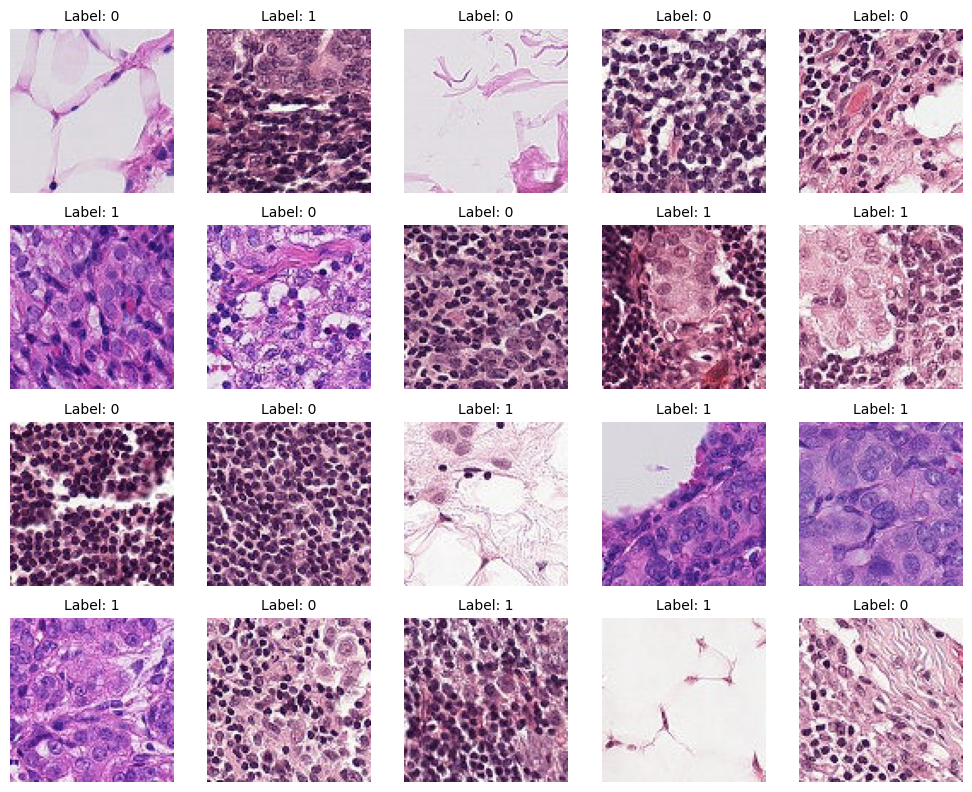

In [18]:
# Convert train_labels data into a pandas DataFrame with two columns: "id" and "label"
train_labels = pd.DataFrame(train_labels, columns=["id", "label"])

# Display the first few rows of the train_labels DataFrame to check its content
display(train_labels.head())

# Define a function to display sample images along with their labels
def display_sample_images_fixed(image_ids, directory, labels, rows=4, cols=5):
    sample_ids = random.sample(list(image_ids), rows * cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))  
    axes = axes.flatten()

    for i, image_id in enumerate(sample_ids):
        img_path = os.path.join(directory, image_id + ".tif")
        label = labels.loc[labels["id"] == image_id, "label"].values[0]
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}", fontsize=10)
        axes[i].axis("off")
    plt.tight_layout(pad=1.0)
    plt.show()

# Call the function to display 4 rows and 5 columns of sample images with their labels
display_sample_images_fixed(train_labels["id"], train_dir, train_labels, rows=4, cols=5)

1. **Label 0**
    - Represents a negative sample, where the patch does not contain metastatic cancer. Negative samples tend to have more uniform structures or appear lighter in texture.
  
2. **Label 1**
    - Represents a positive sample, indicating the presence of metastatic cancer. Positive samples often exhibit denser cell clusters and darker regions, suggesting the presence of cancer.
  
- This dataset forms the foundation for training and evaluating our machine learning models, with a focus on binary classification for detecting metastatic cancer.

#### 1.2.2 Analyze Sample Distribution

Positive samples: 89117, Negative samples: 130908


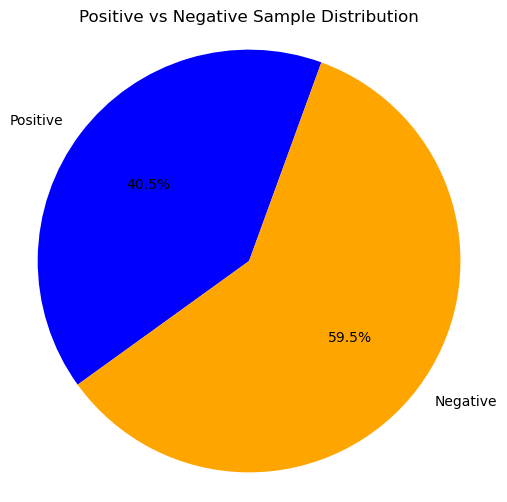

In [27]:
# Count the number of positive samples (where the label is 1) in the training labels
# Count the number of negative samples (where the label is 0) in the training labels
positive_count = train_labels.loc[train_labels['label'] == 1].shape[0]
negative_count = train_labels.loc[train_labels['label'] == 0].shape[0]
print(f"Positive samples: {positive_count}, Negative samples: {negative_count}")

labels = ['Positive', 'Negative']
counts = [positive_count, negative_count]
colors = ['blue', 'orange']
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=70)
plt.title('Positive vs Negative Sample Distribution')
plt.axis('equal')  
plt.show()

- The dataset is characterized by a class imbalance, with significantly more negative samples than positive samples. To mitigate this, techniques like SMOTE (Synthetic Minority Oversampling Technique) and data augmentation were applied during analytics. 

#### 1.2.3 Analyze Positive and Negative Sample Features

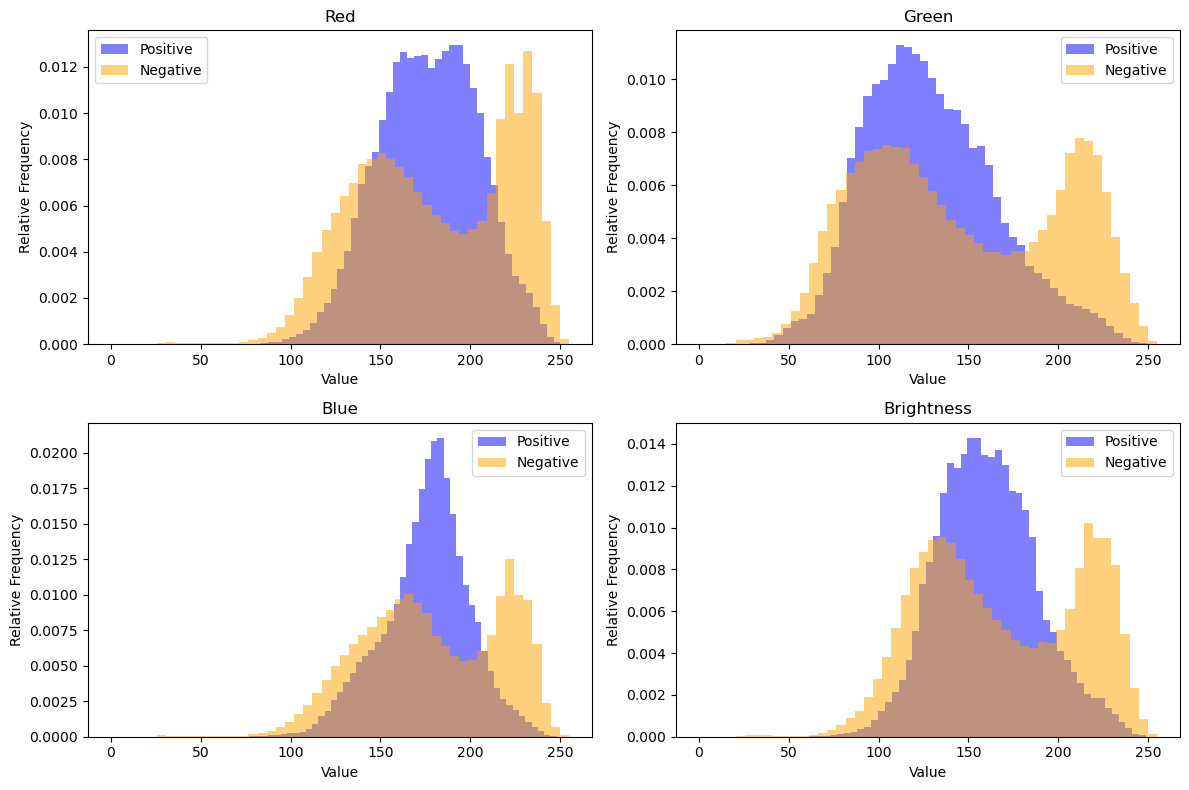

In [29]:
# Compare RGB channels, brightness for positive and negative samples
def calculate_channel_and_brightness_means(image_ids, directory):
    red_means, green_means, blue_means, brightness_means = [], [], [], []
    for img_id in image_ids:
        img_path = os.path.join(directory, img_id + ".tif")
        img = np.array(Image.open(img_path))
        red_means.append(img[:, :, 0].mean())
        green_means.append(img[:, :, 1].mean())
        blue_means.append(img[:, :, 2].mean())
        brightness_means.append(img.mean())  
    return red_means, green_means, blue_means, brightness_means

positive_ids = train_labels[train_labels['label'] == 1]['id'].values
negative_ids = train_labels[train_labels['label'] == 0]['id'].values
pos_red, pos_green, pos_blue, pos_brightness = calculate_channel_and_brightness_means(positive_ids, train_dir)
neg_red, neg_green, neg_blue, neg_brightness = calculate_channel_and_brightness_means(negative_ids, train_dir)
features = {
    "Red": (pos_red, neg_red),
    "Green": (pos_green, neg_green),
    "Blue": (pos_blue, neg_blue),
    "Brightness": (pos_brightness, neg_brightness)
}

plt.figure(figsize=(12, 8))
for i, (feature_name, (pos_values, neg_values)) in enumerate(features.items(), 1):
    plt.subplot(2, 2, i)
    plt.hist(pos_values, bins=50, alpha=0.5, label='Positive', color='blue', density=True)
    plt.hist(neg_values, bins=50, alpha=0.5, label='Negative', color='orange', density=True)
    plt.title(feature_name)
    plt.xlabel('Value')
    plt.ylabel('Relative Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

**Distributions of color channel values (Red, Green, Blue) and overall brightness.**
- Red Panel: Cancer samples ("Positive," blue) and non-cancer samples ("Negative," orange) show slightly overlapping distributions. However, the blue area tends to lean toward higher red values compared to the orange.
- Green Panel: Similar to the red panel, but with a more distinct shift. Positive samples tend to have higher green intensity values than negative ones.
- Blue Panel: Positive samples have a narrower range, clustered around higher blue values, while negative samples show a wider spread.
- Brightness Panel: Positive samples tend to be brighter overall, as seen by the shift of the blue distribution toward higher brightness values.

### 1.3 Dataset Preprocessing

#### 1.3.1 Split Dataset

In [31]:
# Split the training data into two parts: 80% for training (train_set),  20% for validation (val_set)
train_set, val_set = train_test_split(train_labels, test_size=0.2, stratify=train_labels["label"], random_state=42)

# Print the size of the training and validation sets
print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")

train_ids = train_set["id"].values
val_ids = val_set["id"].values
train_labels = train_set["label"].values
val_labels = val_set["label"].values

Training set size: 176020
Validation set size: 44005


#### 1.3.2 Batch Processing and Saving

In [33]:
# Function to process and save data in batches
def process_and_save_batches(image_ids, labels, directory, func, batch_size, output_file):

    #  Check for Already Processed Batches
    existing_batches = set(glob.glob(f"{output_file}_batch_*.pkl"))
    print(f"Found {len(existing_batches)} existing batches. Starting processing...")
    
    # Process Each Batch
    for i in range(0, len(image_ids), batch_size):
        # Check and Skip Processed Batches
        batch_file = f"{output_file}_batch_{i // batch_size}.pkl"
        if batch_file in existing_batches:
            print(f"Skipping already processed batch: {batch_file}")
            continue
        # Process the Current Batch   
        batch_ids = image_ids[i:i + batch_size]
        batch_labels = labels[i:i + batch_size]
        batch_data = np.array([func(img_id, directory) for img_id in batch_ids])
        #  Save the Batch
        with open(batch_file, "wb") as f:
            pickle.dump((batch_data, batch_labels), f)
        print(f"Saved: {batch_file}")
        # Clean Up
        del batch_data, batch_labels
        gc.collect()
    print("All batches processed.")

- When working with large datasets, especially image datasets, batch processing and saving are crucial techniques for efficiently managing memory, processing time and data reusability.

#### 1.3.3 Flatten images (For Naive Bayes and Random Forest)

In [35]:
# Defines the number of images to process at a time. This helps manage memory usage and speeds up processing.
BATCH_SIZE = 400
# Function to flatten an image into a 1D array
def flatten_image(img_id, directory):
    img_path = os.path.join(directory, img_id + ".tif")
    img = Image.open(img_path)
    return np.array(img).flatten()
# Process and save batches of training and validation data    
process_and_save_batches(train_ids, train_labels, train_dir, flatten_image, BATCH_SIZE, "train_raw")
process_and_save_batches(val_ids, val_labels, train_dir, flatten_image, BATCH_SIZE, "val_raw")
print("Processing complete. Exiting now.")

Found 0 existing batches. Starting processing...
Saved: train_raw_batch_0.pkl
Saved: train_raw_batch_1.pkl
Saved: train_raw_batch_2.pkl
Saved: train_raw_batch_3.pkl
Saved: train_raw_batch_4.pkl
Saved: train_raw_batch_5.pkl
Saved: train_raw_batch_6.pkl
Saved: train_raw_batch_7.pkl
Saved: train_raw_batch_8.pkl
Saved: train_raw_batch_9.pkl
Saved: train_raw_batch_10.pkl
Saved: train_raw_batch_11.pkl
Saved: train_raw_batch_12.pkl
Saved: train_raw_batch_13.pkl
Saved: train_raw_batch_14.pkl
Saved: train_raw_batch_15.pkl
Saved: train_raw_batch_16.pkl
Saved: train_raw_batch_17.pkl
Saved: train_raw_batch_18.pkl
Saved: train_raw_batch_19.pkl
Saved: train_raw_batch_20.pkl
Saved: train_raw_batch_21.pkl
Saved: train_raw_batch_22.pkl
Saved: train_raw_batch_23.pkl
Saved: train_raw_batch_24.pkl
Saved: train_raw_batch_25.pkl
Saved: train_raw_batch_26.pkl
Saved: train_raw_batch_27.pkl
Saved: train_raw_batch_28.pkl
Saved: train_raw_batch_29.pkl
Saved: train_raw_batch_30.pkl
Saved: train_raw_batch_31.pkl
S

- An image is typically a 2D array of pixel values for grayscale images or a 3D array for RGB images (height × width × color channels). Flattening transforms this multidimensional array into a 1D array (a single row of pixel values). For example, a 100×100 RGB image (100×100×3) becomes a 1D array with 30,000 values.

- Compatibility with Machine Learning Algorithms: Many traditional machine learning algorithms (e.g., Naive Bayes, Logistic Regression, SVM) require input as 1D vectors rather than 2D or 3D arrays. Flattening converts the image into a format suitable for these algorithms.

#### 1.3.4 Standardization (For logistic regression and SVM)

In [41]:
# Function to standardize (normalize) a single image using a scaler
def standardize_image(img_id, directory, scaler=None):
    img_path = os.path.join(directory, img_id + ".tif")
    img = np.array(Image.open(img_path).flatten())
    if scaler:
        img = scaler.transform([img])[0]  
    return img
# Define batch size for processing images in smaller groups    
BATCH_SIZE_STD = 250  
scaler = StandardScaler()
# Loop through the training image IDs in batches
for batch_idx in range(0, len(train_ids), BATCH_SIZE_STD):
    batch_ids = train_ids[batch_idx:batch_idx + BATCH_SIZE_STD]
    batch_data = [np.array(Image.open(os.path.join(train_dir, img_id + ".tif"))).flatten() for img_id in batch_ids]
    scaler.partial_fit(batch_data)  
    print(f"Scaler partial fit completed for batch {batch_idx // BATCH_SIZE_STD + 1}")

#with open("scaler.pkl", "wb") as f:
#    pickle.dump(scaler, print("Scaler fitted and saved."))
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)  # Save the scaler object to the file
print("Scaler fitted and saved.")

# Function to standardize images using the pre-trained scaler
def standardize_with_scaler(img_id, directory):
    img_path = os.path.join(directory, img_id + ".tif")
    img = np.array(Image.open(img_path)).flatten()
    return scaler.transform([img])[0]  
process_and_save_batches(train_ids, train_labels, train_dir, standardize_with_scaler, BATCH_SIZE_STD, "train_standardized")
process_and_save_batches(val_ids, val_labels, train_dir, standardize_with_scaler, BATCH_SIZE_STD, "val_standardized")
print("Standardization completed and standardized batches saved.")

Scaler partial fit completed for batch 1
Scaler partial fit completed for batch 2
Scaler partial fit completed for batch 3
Scaler partial fit completed for batch 4
Scaler partial fit completed for batch 5
Scaler partial fit completed for batch 6
Scaler partial fit completed for batch 7
Scaler partial fit completed for batch 8
Scaler partial fit completed for batch 9
Scaler partial fit completed for batch 10
Scaler partial fit completed for batch 11
Scaler partial fit completed for batch 12
Scaler partial fit completed for batch 13
Scaler partial fit completed for batch 14
Scaler partial fit completed for batch 15
Scaler partial fit completed for batch 16
Scaler partial fit completed for batch 17
Scaler partial fit completed for batch 18
Scaler partial fit completed for batch 19
Scaler partial fit completed for batch 20
Scaler partial fit completed for batch 21
Scaler partial fit completed for batch 22
Scaler partial fit completed for batch 23
Scaler partial fit completed for batch 24
S

In [43]:
# Function to combine all processed batches into a single file
def combine_batches(batch_prefix, output_file):
     # Initialize empty lists to store all data and labels
    all_data, all_labels = [], []
    for batch_file in sorted(glob.glob(f"{batch_prefix}_batch_*.pkl")):
        with open(batch_file, "rb") as f:
            batch_data, batch_labels = pickle.load(f)
            all_data.append(batch_data)
            all_labels.append(batch_labels)
    # Combine all batch data into a single array        
    combined_data = np.concatenate(all_data)
    # Combine all batch labels into a single array
    combined_labels = np.concatenate(all_labels)
    # Save the combined data and labels into a single output file
    with open(output_file, "wb") as f:
        pickle.dump((combined_data, combined_labels), f)
    print(f"Combined and saved: {output_file}")
# Combine batches for training data into a single file    
combine_batches("train_raw", "train_images_raw.pkl")
# Combine batches for validation data into a single file
combine_batches("val_raw", "val_images_raw.pkl")

Combined and saved: train_images_raw.pkl
Combined and saved: val_images_raw.pkl


#### 1.3.5 Data Augmentation (For Neural Network and XGboost)
 - Applied random flips and resizing to enhance diversity and generalization.

In [45]:
# Function to resize, augment, and normalize images
def resize_augment_normalize_image(img_id, directory):
    img_path = os.path.join(directory, img_id + ".tif")
    # Define a series of image transformations:
    # 1. Resize the image to 64x64 pixels.
    # 2. Apply a random horizontal flip (mirroring the image).
    # 3. Convert the image to a tensor (a format that machine learning models can understand).
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  
        transforms.RandomHorizontalFlip(),  
        transforms.ToTensor()  
    ])
    # Open the image, apply the transformations, and flatten the image (convert it into a 1D array)
    img = transform(Image.open(img_path)).numpy().flatten()  
    # Normalize the pixel values to be between 0 and 1 (original range is 0-255)
    return img / 255.0  

# Set the batch size for processing images 
BATCH_SIZE_AN=250
# Process the training and validation data (resize, augment, normalize) and save in batches
process_and_save_batches(train_ids, train_labels, train_dir, resize_augment_normalize_image, BATCH_SIZE_AN, "train_normalized_augmented")
process_and_save_batches(val_ids, val_labels, train_dir, resize_augment_normalize_image, BATCH_SIZE_AN, "val_normalized_augmented")
print("Preprocessing complete. Datasets saved.")

Found 0 existing batches. Starting processing...
Saved: train_normalized_augmented_batch_0.pkl
Saved: train_normalized_augmented_batch_1.pkl
Saved: train_normalized_augmented_batch_2.pkl
Saved: train_normalized_augmented_batch_3.pkl
Saved: train_normalized_augmented_batch_4.pkl
Saved: train_normalized_augmented_batch_5.pkl
Saved: train_normalized_augmented_batch_6.pkl
Saved: train_normalized_augmented_batch_7.pkl
Saved: train_normalized_augmented_batch_8.pkl
Saved: train_normalized_augmented_batch_9.pkl
Saved: train_normalized_augmented_batch_10.pkl
Saved: train_normalized_augmented_batch_11.pkl
Saved: train_normalized_augmented_batch_12.pkl
Saved: train_normalized_augmented_batch_13.pkl
Saved: train_normalized_augmented_batch_14.pkl
Saved: train_normalized_augmented_batch_15.pkl
Saved: train_normalized_augmented_batch_16.pkl
Saved: train_normalized_augmented_batch_17.pkl
Saved: train_normalized_augmented_batch_18.pkl
Saved: train_normalized_augmented_batch_19.pkl
Saved: train_normaliz

## 2. Model Training and Comparison

### 2.1 Naive Bayes

1. **Key Features**
    - Assumes independence between features.
    - Efficient for large datasets.
2. **Preprocessing**
    - Used raw pixel values without scaling or normalization.

In [47]:
# Function to load pre-processed batches of data from files
def load_batches(batch_prefix):
    import glob
    import pickle
    for batch_file in sorted(glob.glob(f"{batch_prefix}_batch_*.pkl")):
        with open(batch_file, "rb") as f:
            batch_data, batch_labels = pickle.load(f)
            yield batch_data, batch_labels

# Create a Naive Bayes model for classification
naive_bayes_model = GaussianNB()

# Train the model in batches using the pre-processed training data
for train_batch, train_labels_batch in load_batches("train_raw"):
    naive_bayes_model.partial_fit(train_batch, train_labels_batch, classes=np.array([0, 1]))  # Use `partial_fit` for batch learning
print("Naive Bayes model training completed.")

# Initialize lists to store all validation labels and predictions
all_val_labels = []
all_val_predictions = []

for val_batch, val_labels_batch in load_batches("val_raw"):
    val_predictions_batch = naive_bayes_model.predict(val_batch)
    all_val_labels.extend(val_labels_batch)
    all_val_predictions.extend(val_predictions_batch)
all_val_labels = np.array(all_val_labels)
all_val_predictions = np.array(all_val_predictions)


accuracy = accuracy_score(all_val_labels, all_val_predictions)
print(f"Validation Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(all_val_labels, all_val_predictions, target_names=["Negative", "Positive"]))
print("Confusion Matrix:")
print(confusion_matrix(all_val_labels, all_val_predictions))

# Save the trained model to a file for later use
dump(naive_bayes_model, "naive_bayes_model.joblib")
print("Naive Bayes model saved.")

Naive Bayes model training completed.
Validation Accuracy: 0.73
Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.70      0.76     26182
    Positive       0.64      0.78      0.70     17823

    accuracy                           0.73     44005
   macro avg       0.73      0.74      0.73     44005
weighted avg       0.75      0.73      0.73     44005

Confusion Matrix:
[[18333  7849]
 [ 4008 13815]]
Naive Bayes model saved.


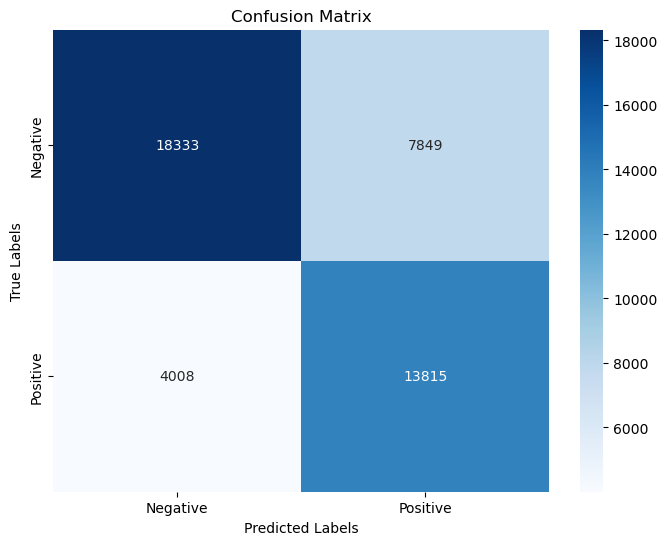

In [49]:
conf_matrix = confusion_matrix(all_val_labels, all_val_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

### 2.2 Random Forest

1. **Key Features**
    - Ensemble method using decision trees.
    - Captures feature importance and non-linear relationships.

Random Forest model training completed.
Validation Accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

    Negative       0.74      0.89      0.81     26182
    Positive       0.78      0.55      0.64     17823

    accuracy                           0.75     44005
   macro avg       0.76      0.72      0.73     44005
weighted avg       0.76      0.75      0.74     44005

Confusion Matrix:
[[23362  2820]
 [ 8088  9735]]


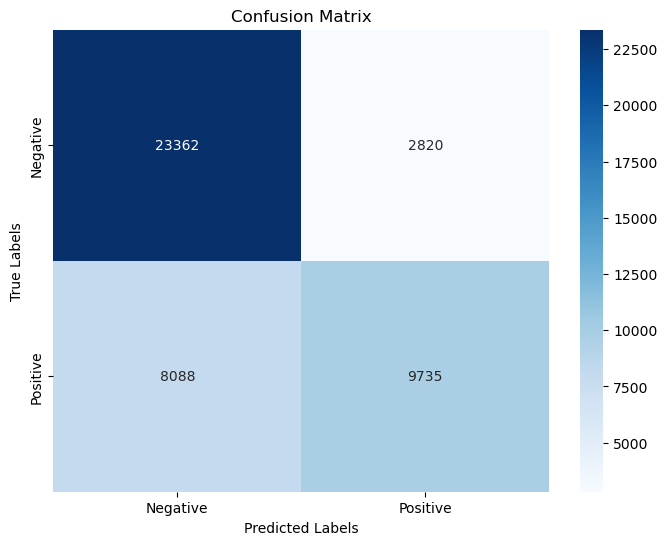

Random Forest model saved.


In [51]:
# Function to load data batches
def load_batches(batch_prefix):
    for batch_file in sorted(glob.glob(f"{batch_prefix}_batch_*.pkl")):
        with open(batch_file, "rb") as f:
            batch_data, batch_labels = pickle.load(f)
            yield batch_data, batch_labels

# Training the Model
random_forest_model = RandomForestClassifier(random_state=42)
for train_batch, train_labels_batch in load_batches("train_raw"):
    random_forest_model.fit(train_batch, train_labels_batch)  
print("Random Forest model training completed.")

# Evaluate the model on validation data batches
all_val_labels = []
all_val_predictions = []
for val_batch, val_labels_batch in load_batches("val_raw"):
    val_predictions_batch = random_forest_model.predict(val_batch)
    all_val_labels.extend(val_labels_batch)
    all_val_predictions.extend(val_predictions_batch)
# Convert the collected validation labels and predictions into NumPy arrays
all_val_labels = np.array(all_val_labels)
all_val_predictions = np.array(all_val_predictions)

# Evaluation
accuracy = accuracy_score(all_val_labels, all_val_predictions)
print(f"Validation Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(all_val_labels, all_val_predictions, target_names=["Negative", "Positive"]))
conf_matrix = confusion_matrix(all_val_labels, all_val_predictions)
print("Confusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
# Save the trained Random Forest model to a file for future use
dump(random_forest_model, "random_forest_model.joblib")
print("Random Forest model saved.")

### 2.3 Logistic Regression

1. **Key Features**
    - Linear classification model.
    - Uses sigmoid activation to predict probabilities.
2. **Enhancements**
    - Added L2 regularization for improved generalization.
    - Applied probability calibration (Isotonic Regression).
    - Logistic Regression inherently outputs probabilities for binary classification. However, these probabilities are not always well-calibrated, especially in cases with imbalanced datasets or when regularization is applied during training. Calibration ensures that the predicted probabilities are aligned with the true likelihood of an event.
    - we used Isotonic Regression because it works well with more complex probability distributions.

python(5804) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Logistic Regression model training completed.
Probability calibration completed.
Validation Accuracy: 0.63
Classification Report:
              precision    recall  f1-score   support

    Negative       0.66      0.79      0.72     26182
    Positive       0.57      0.41      0.47     17823

    accuracy                           0.63     44005
   macro avg       0.61      0.60      0.60     44005
weighted avg       0.62      0.63      0.62     44005

Confusion Matrix:
[[20616  5566]
 [10544  7279]]


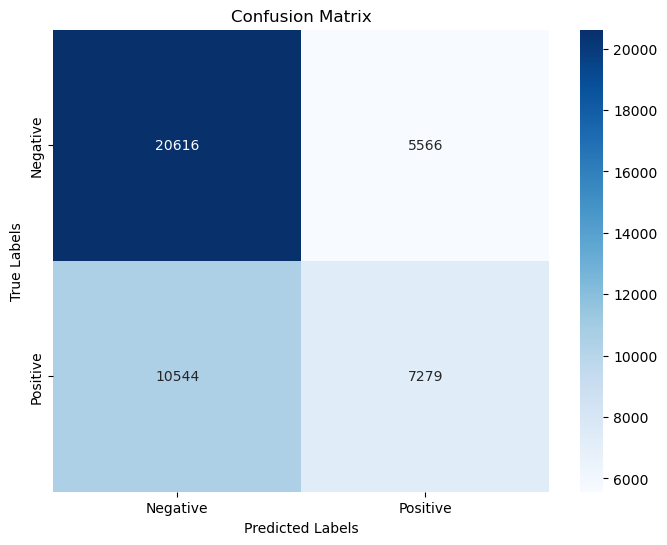

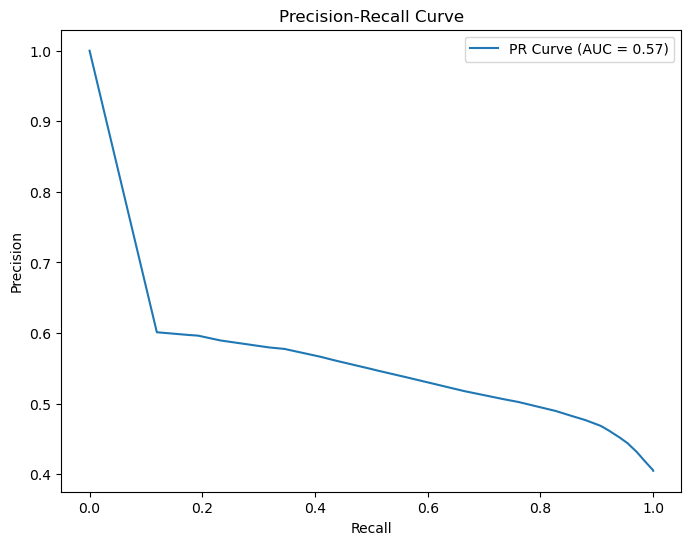

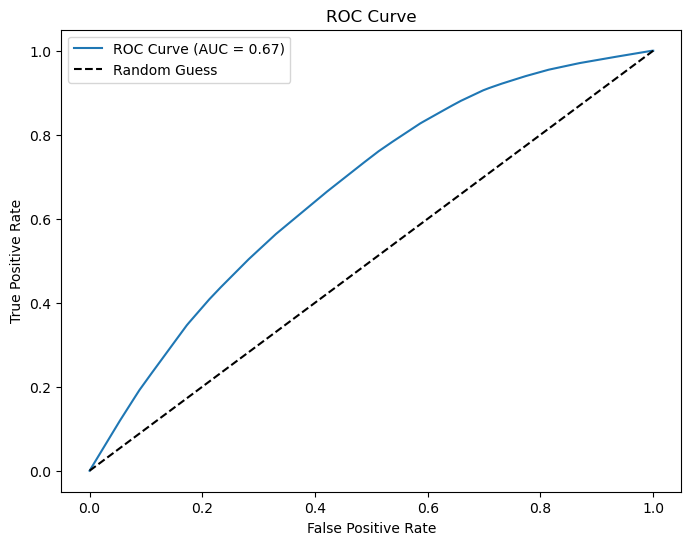

Calibrated Logistic Regression model saved.


In [55]:
# Function to load processed data batches
from sklearn.linear_model import SGDClassifier


def load_batches(batch_prefix):
    for batch_file in sorted(glob.glob(f"{batch_prefix}_batch_*.pkl")):
        with open(batch_file, "rb") as f:
            batch_data, batch_labels = pickle.load(f)
            yield batch_data, batch_labels
            
# Function to combine all validation batches into a single dataset
def combine_validation_batches(batch_prefix):
    all_data, all_labels = [], []
    for val_batch, val_labels_batch in load_batches(batch_prefix):
        all_data.extend(val_batch)
        all_labels.extend(val_labels_batch)
    return np.array(all_data), np.array(all_labels)

# Load all validation data and labels
val_data, val_labels = combine_validation_batches("val_standardized")

# Initialize a logistic regression model using Stochastic Gradient Descent
logistic_model = SGDClassifier(
    loss="log_loss", penalty="l2", max_iter=1000, tol=1e-3, random_state=42
)
# print("Training Logistic Regression with Batches...")
first_batch = True
for train_batch, train_labels_batch in load_batches("train_standardized"):
    if first_batch:
        smote = SMOTE(random_state=42)
        train_batch, train_labels_batch = smote.fit_resample(train_batch, train_labels_batch)
        logistic_model.fit(train_batch, train_labels_batch)  
        first_batch = False
    else:
        logistic_model.fit(train_batch, train_labels_batch)  
print("Logistic Regression model training completed.")

# Calibrate the model to output better probabilities
calibrated_model = CalibratedClassifierCV(estimator=logistic_model, method='isotonic', cv='prefit')
calibrated_model.fit(val_data, val_labels)
print("Probability calibration completed.")

# Evaluation
val_probabilities = calibrated_model.predict_proba(val_data)[:, 1]  
val_predictions = (val_probabilities > 0.5).astype(int) 
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(val_labels, val_predictions, target_names=["Negative", "Positive"]))
conf_matrix = confusion_matrix(val_labels, val_predictions)
print("Confusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

precision, recall, _ = precision_recall_curve(val_labels, val_probabilities)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

fpr, tpr, _ = roc_curve(val_labels, val_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Save the calibrated model to a file for future use
dump(calibrated_model, "logistic_regression_calibrated.joblib")
print("Calibrated Logistic Regression model saved.")

### 2.4 SVM

1. **Key Features**
    - Finds an optimal hyperplane for classification.
    - Uses kernel functions for non-linear decision boundaries.

SVM model training completed.
Evaluating on Validation Set...
Validation Accuracy: 0.76
Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.79      0.80     26182
    Positive       0.70      0.73      0.72     17823

    accuracy                           0.76     44005
   macro avg       0.76      0.76      0.76     44005
weighted avg       0.77      0.76      0.77     44005

Confusion Matrix:
[[20575  5607]
 [ 4742 13081]]


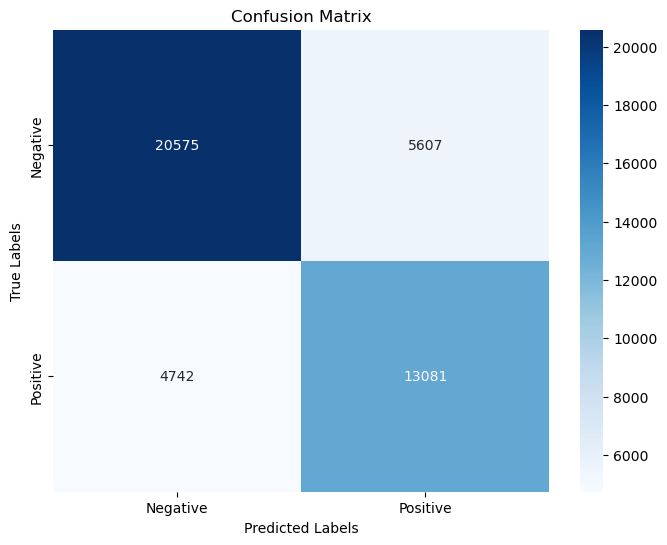

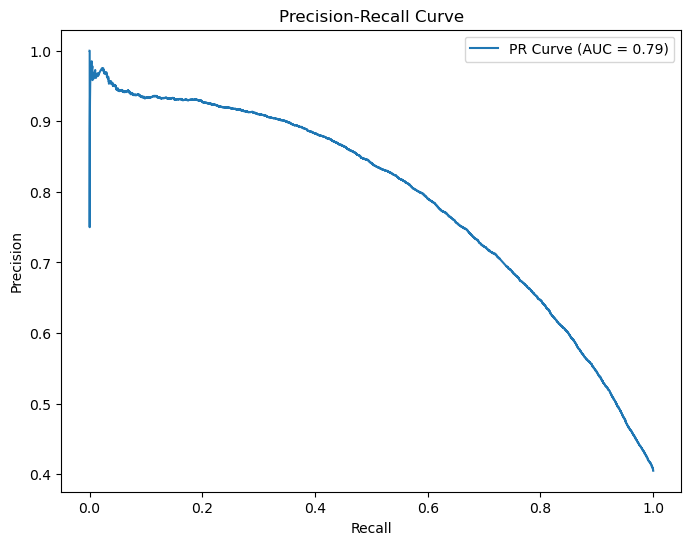

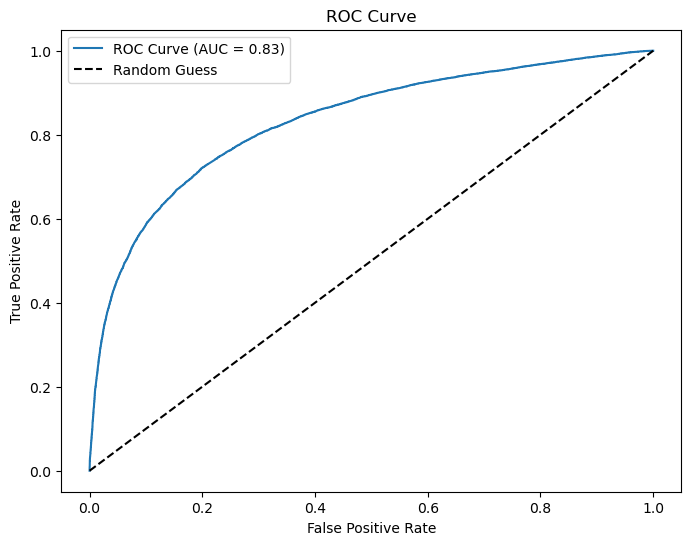

SVM model saved.


In [58]:
# Function to load data batches from files
def load_batches(batch_prefix):
    for batch_file in sorted(glob.glob(f"{batch_prefix}_batch_*.pkl")):
        with open(batch_file, "rb") as f:
            batch_data, batch_labels = pickle.load(f)
            yield batch_data, batch_labels
            
# Initialize and train an SVM model
#print("Training SVM with Batches...")
svm_model = SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=42)  
for train_batch, train_labels_batch in load_batches("train_standardized"):
    svm_model.fit(train_batch, train_labels_batch)  
print("SVM model training completed.")
print("Evaluating on Validation Set...")
all_val_labels = []
all_val_predictions = []
all_val_probabilities = []

# Process the validation data in batches
for val_batch, val_labels_batch in load_batches("val_standardized"):
    val_predictions_batch = svm_model.predict(val_batch)
    val_probabilities_batch = svm_model.predict_proba(val_batch)[:, 1]  
    all_val_labels.extend(val_labels_batch)
    all_val_predictions.extend(val_predictions_batch)
    all_val_probabilities.extend(val_probabilities_batch)
# Convert lists to numpy arrays for further analysis    
all_val_labels = np.array(all_val_labels)
all_val_predictions = np.array(all_val_predictions)
all_val_probabilities = np.array(all_val_probabilities)

# Evaluation
accuracy = accuracy_score(all_val_labels, all_val_predictions)
print(f"Validation Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(all_val_labels, all_val_predictions, target_names=["Negative", "Positive"]))
conf_matrix = confusion_matrix(all_val_labels, all_val_predictions)
print("Confusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

precision, recall, _ = precision_recall_curve(all_val_labels, all_val_probabilities)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

fpr, tpr, _ = roc_curve(all_val_labels, all_val_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Save the trained SVM model to a file
dump(svm_model, "svm_model_with_curves.joblib")
print("SVM model saved.")

### 2.5 Neural Network

#### 2.5.1 Neural Network 1

#### Initial Implementation

1. **Architecture:**
    - Input Layer: 1024 neurons (flattened image).
    - Hidden Layers: 2 layers with 512 and 256 neurons.
    - Activation: ReLU for hidden layers, Sigmoid for the output layer.
    - Dropout: Added 20% dropout to reduce overfitting.
2. **Training:**
    - Batch Size: 32
    - Epochs: 5
    - Optimizer: Adam
    - Learning Rate: 0.001
3. **Data Handling:**
    - Used normalized and augmented training data.
    - Did not explicitly address class imbalance.

Training Neural Network with Batches...
Neural Network training completed.
Evaluating on Validation Set...
Validation Accuracy: 0.71
Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.66      0.73     26182
    Positive       0.61      0.79      0.69     17823

    accuracy                           0.71     44005
   macro avg       0.72      0.72      0.71     44005
weighted avg       0.74      0.71      0.71     44005

Confusion Matrix:
[[17210  8972]
 [ 3717 14106]]


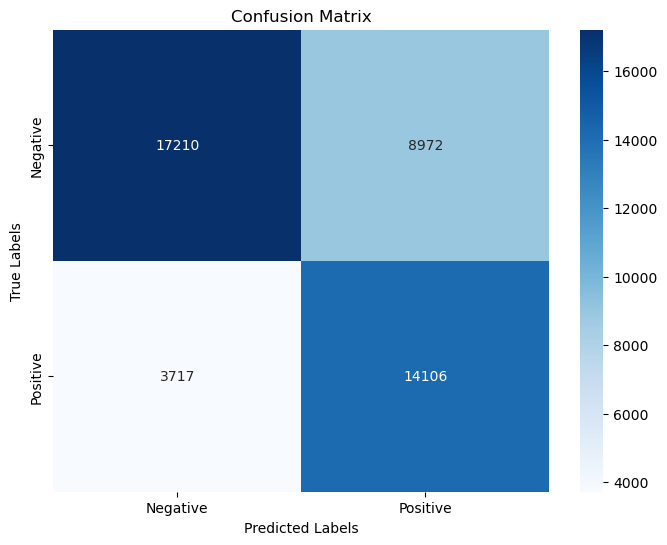

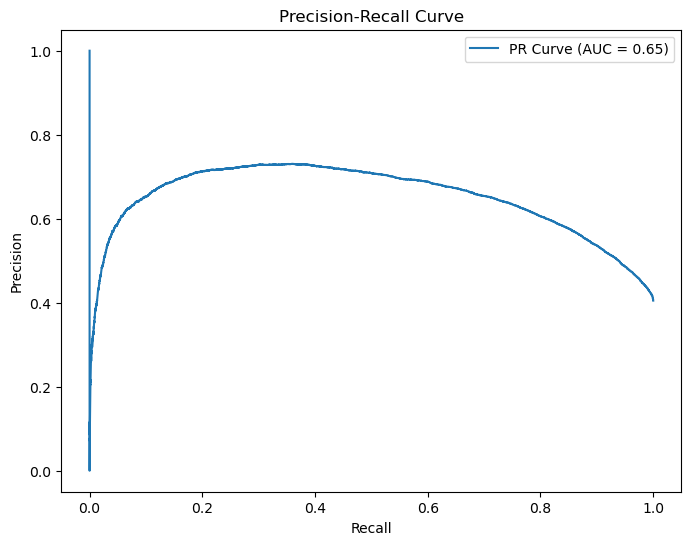

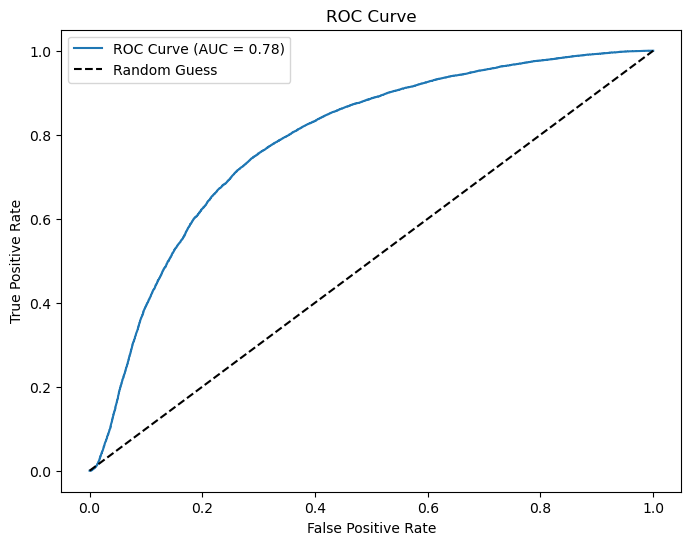

Neural Network model saved.


In [62]:
# Check if GPU is available for faster processing; otherwise, use CPU

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to load batches of preprocessed data from saved files
def load_batches(batch_prefix):
    for batch_file in sorted(glob.glob(f"{batch_prefix}_batch_*.pkl")):
        with open(batch_file, "rb") as f:
            batch_data, batch_labels = pickle.load(f)
            yield batch_data, batch_labels

# Define a simple Neural Network structure
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(64 * 64 * 3, 256),  
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  
        )
 # Define how the input data flows through the network
    def forward(self, x):
        return self.fc(x)
        
# Initialize the Neural Network and move it to the device (CPU/GPU)
model = NeuralNetwork().to(device)
# Define the loss function (Binary Cross-Entropy Loss for binary classification)
criterion = nn.BCELoss()  
# Define the optimizer (Adam optimizer for updating weights during training)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Start training the Neural Network
print("Training Neural Network with Batches...")
model.train()
for train_batch, train_labels_batch in load_batches("train_normalized_augmented"):
    train_batch = torch.tensor(train_batch, dtype=torch.float32).to(device)
    train_labels_batch = torch.tensor(train_labels_batch, dtype=torch.float32).view(-1, 1).to(device)
    outputs = model(train_batch)     # Forward pass: Get predictions from the model
    loss = criterion(outputs, train_labels_batch)     # Calculate the loss
    optimizer.zero_grad()     # Zero the gradients to prevent accumulation
    loss.backward()    # Backward pass: Compute gradients
    optimizer.step()     # Update model weights
print("Neural Network training completed.")


# Evaluate the model on the validation set
print("Evaluating on Validation Set...")
model.eval()
all_val_labels = []
all_val_predictions = []
all_val_probabilities = []

# Disable gradient computation during evaluation for efficiency
with torch.no_grad():
    for val_batch, val_labels_batch in load_batches("val_normalized_augmented"):
        # Convert validation data to tensors and move them to the device
        val_batch = torch.tensor(val_batch, dtype=torch.float32).to(device)
        val_labels_batch = np.array(val_labels_batch)
        # Get model probabilities for each input
        probabilities = model(val_batch).cpu().numpy().flatten()
        predictions = (probabilities > 0.5).astype(int)  # Threshold at 0.5
        # Collect true labels, predicted labels, and probabilities for later analysis
        all_val_labels.extend(val_labels_batch)
        all_val_predictions.extend(predictions)
        all_val_probabilities.extend(probabilities)
all_val_labels = np.array(all_val_labels)
all_val_predictions = np.array(all_val_predictions)
all_val_probabilities = np.array(all_val_probabilities)

accuracy = accuracy_score(all_val_labels, all_val_predictions)
print(f"Validation Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(all_val_labels, all_val_predictions, target_names=["Negative", "Positive"]))
conf_matrix = confusion_matrix(all_val_labels, all_val_predictions)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

precision, recall, _ = precision_recall_curve(all_val_labels, all_val_probabilities)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

fpr, tpr, _ = roc_curve(all_val_labels, all_val_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

torch.save(model.state_dict(), "neural_network_model.pth")
print("Neural Network model saved.")

## Improved Neural Network Model

Building on the original **Neural Network model**, the following improvements were made:

1. **Neural Network Architecture**
    - **Increased Neurons**: Added more neurons in each layer to enhance the network's capacity to capture complex patterns.
    - **Activation Functions**: Replaced standard ReLU with **LeakyReLU** for better gradient flow and used ReLU in the final hidden layer.
    - **Dropout Layers**: Introduced dropout layers to prevent overfitting.

2. **Hyperparameters**
    - **Learning Rate**: Adjusted the learning rate to `0.0005` for more stable training.
    - **Optimizer**: Switched to **AdamW** for effective weight decay (L2 regularization).
    - **Batch Size**: Set to `64` for balanced updates.
    - **Epochs**: Increased to `10` for improved convergence and performance.

3. **Class Imbalance**
    - Addressed class imbalance using **SMOTE** to oversample minority classes and ensure balanced training.

4. **Data Augmentation**
    - Continued to use **normalized and augmented training data** for improved generalization.


#### 2.5.2 Optimized Neural Network

Training Optimized Neural Network with Batches...
Epoch 1/30
Epoch 1 completed. Loss: 0.5699
Epoch 2/30
Epoch 2 completed. Loss: 0.5695
Epoch 3/30
Epoch 3 completed. Loss: 0.5603
Epoch 4/30
Epoch 4 completed. Loss: 0.5587
Epoch 5/30
Epoch 5 completed. Loss: 0.5642
Epoch 6/30
Epoch 6 completed. Loss: 0.5526
Epoch 7/30
Epoch 7 completed. Loss: 0.5568
Epoch 8/30
Epoch 8 completed. Loss: 0.5910
Epoch 9/30
Epoch 9 completed. Loss: 0.5413
Epoch 10/30
Epoch 10 completed. Loss: 0.5401
Epoch 11/30
Epoch 11 completed. Loss: 0.5427
Epoch 12/30
Epoch 12 completed. Loss: 0.5351
Epoch 13/30
Epoch 13 completed. Loss: 0.5314
Epoch 14/30
Epoch 14 completed. Loss: 0.5562
Epoch 15/30
Epoch 15 completed. Loss: 0.5193
Epoch 16/30
Epoch 16 completed. Loss: 0.5450
Epoch 17/30
Epoch 17 completed. Loss: 0.5582
Epoch 18/30
Epoch 18 completed. Loss: 0.5271
Epoch 19/30
Epoch 19 completed. Loss: 0.5534
Epoch 20/30
Epoch 20 completed. Loss: 0.5251
Epoch 21/30
Epoch 21 completed. Loss: 0.5180
Epoch 22/30
Epoch 22 co

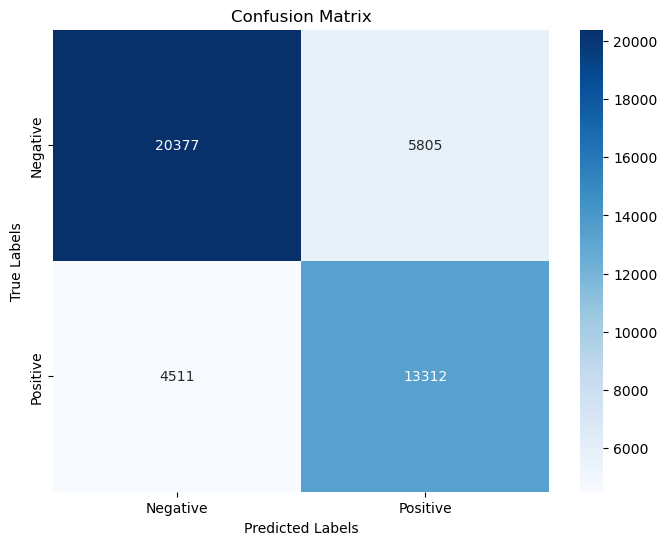

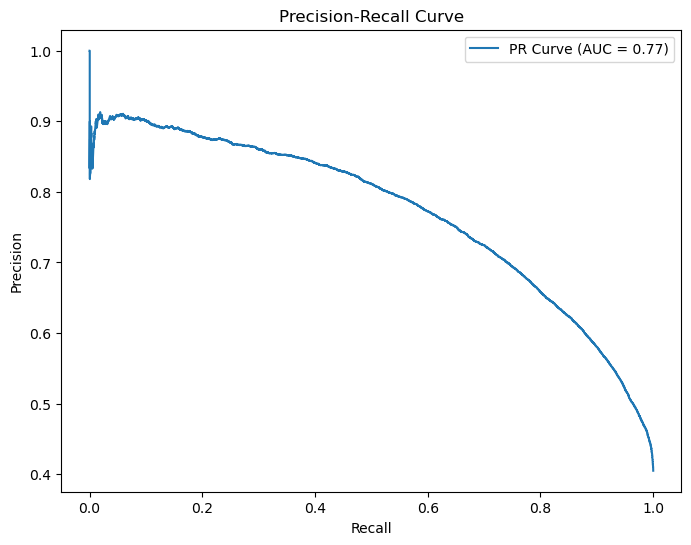

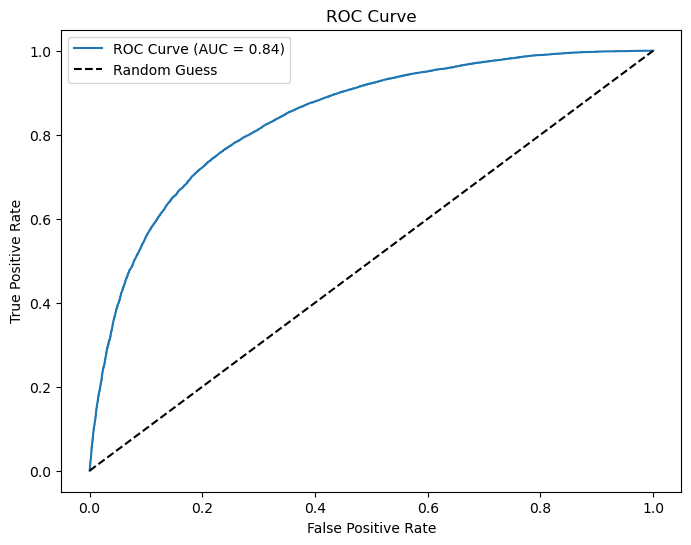

Optimized Neural Network model saved.


In [64]:
# Check if a GPU is available for faster computations, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to load batches of data from saved files
def load_batches(batch_prefix):
    for batch_file in sorted(glob.glob(f"{batch_prefix}_batch_*.pkl")):
        with open(batch_file, "rb") as f:
            batch_data, batch_labels = pickle.load(f)
            yield batch_data, batch_labels

# Function to oversample data using SMOTE to handle class imbalance
def oversample_with_smote(data, labels):
    smote = SMOTE(random_state=42)
    data_resampled, labels_resampled = smote.fit_resample(data, labels)
    return data_resampled, labels_resampled

# Define the Neural Network Model
class OptimizedNeuralNetwork(nn.Module):
    def __init__(self):
        super(OptimizedNeuralNetwork, self).__init__()
        # Define layers for the neural network
        self.fc = nn.Sequential(
            nn.Linear(64 * 64 * 3, 512),  
            nn.LeakyReLU(),  
            nn.Dropout(0.3),  
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  
        )

    def forward(self, x):
        return self.fc(x)

# Instantiate the model and send it to the device (GPU or CPU)
model = OptimizedNeuralNetwork().to(device)
criterion = nn.BCELoss()    # Define the loss function (measures how wrong predictions are), Binary Cross Entropy for binary classification
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)  # Define the optimizer (helps the model learn during training)
BATCH_SIZE = 64
EPOCHS = 30

# Training the model
print("Training Optimized Neural Network with Batches...")
model.train()
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    for train_batch, train_labels_batch in load_batches("train_normalized_augmented"):
        train_batch = torch.tensor(train_batch, dtype=torch.float32).to(device)
        train_labels_batch = torch.tensor(train_labels_batch, dtype=torch.float32).view(-1, 1).to(device)
        outputs = model(train_batch)
        loss = criterion(outputs, train_labels_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1} completed. Loss: {loss.item():.4f}")

print("Optimized Neural Network training completed.")


# Evaluate the model on the validation dataset
print("Evaluating on Validation Set...")
model.eval()

# Store all validation labels, predictions, and probabilities for evaluation
all_val_labels = []
all_val_predictions = []
all_val_probabilities = []

with torch.no_grad():
    for val_batch, val_labels_batch in load_batches("val_normalized_augmented"):
        val_batch = torch.tensor(val_batch, dtype=torch.float32).to(device)
        val_labels_batch = np.array(val_labels_batch)
        probabilities = model(val_batch).cpu().numpy().flatten()
        predictions = (probabilities > 0.5).astype(int)  #threshold of 0.5
        all_val_labels.extend(val_labels_batch)
        all_val_predictions.extend(predictions)
        all_val_probabilities.extend(probabilities)
        
# Convert all validation results to numpy arrays for easier processing
all_val_labels = np.array(all_val_labels)
all_val_predictions = np.array(all_val_predictions)
all_val_probabilities = np.array(all_val_probabilities)


accuracy = accuracy_score(all_val_labels, all_val_predictions)
print(f"Validation Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(all_val_labels, all_val_predictions, target_names=["Negative", "Positive"]))

conf_matrix = confusion_matrix(all_val_labels, all_val_predictions)
print("Confusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

precision, recall, _ = precision_recall_curve(all_val_labels, all_val_probabilities)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

fpr, tpr, _ = roc_curve(all_val_labels, all_val_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Save the trained model to a file
torch.save(model.state_dict(), "optimized_neural_network_model.pth")
print("Optimized Neural Network model saved.")

### 2.6 XGBoost

1. **Key Features**
    - Gradient boosting framework for tree-based models.
    - Optimized for speed and accuracy.
2. **Hyperparameters**
    - **Learning Rate**: 0.1
    - **Max.depth**: 6
    - **Subsample**: 0.8
    - **Trees**: 100
3. **Strength**
    - Robust to overfitting and handles class imbalance well.
4. **Limitations**
    - Complexity in hyperparameter tuning.

In [1]:
# Load training data and labels from a saved file
with open("train_images_raw.pkl", "rb") as f:
    train_data, train_labels = pickle.load(f)
    
# Load validation data and labels from a saved file
with open("val_images_raw.pkl", "rb") as f:
    val_data, val_labels = pickle.load(f)

# Create an XGBoost classifier model with specific settings
xgb_model = XGBClassifier(
    tree_method = "gpu_hist",
    n_estimators=100,       # Number of trees (boosting rounds)   
    learning_rate=0.1,       # Step size for updating weights during training   
    max_depth=6,              # Maximum depth of each tree  
    objective="binary:logistic",   # Task type (binary classification with probabilities)
    random_state=42            
)

# Train the model using the training data
print("Training XGBoost...")
xgb_model.fit(
    train_data, train_labels,
    eval_set=[(val_data, val_labels)],  
    verbose=True                       
)
print("XGBoost training completed.")

# print("Evaluating on Validation Set...")
# Make predictions on the validation data
val_predictions = xgb_model.predict(val_data)
val_probabilities = xgb_model.predict_proba(val_data)[:, 1] 

accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(val_labels, val_predictions, target_names=["Negative", "Positive"]))
conf_matrix = confusion_matrix(val_labels, val_predictions)
print("Confusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
precision, recall, _ = precision_recall_curve(val_labels, val_probabilities)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

fpr, tpr, _ = roc_curve(val_labels, val_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
dump(xgb_model, "xgboost_model_no_eval_metric.joblib")
print("XGBoost model saved.")

NameError: name 'pickle' is not defined

In [ ]:
CNN

In [37]:
print(train_batch.shape)


(250, 12288)


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import pickle
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Check if a GPU is available for faster computations, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to load batches of data from saved files
def load_batches(batch_prefix):
    for batch_file in sorted(glob.glob(f"{batch_prefix}_batch_*.pkl")):
        with open(batch_file, "rb") as f:
            batch_data, batch_labels = pickle.load(f)
            yield batch_data, batch_labels

# Define the CNN Model
class OptimizedCNN(nn.Module):
    def __init__(self):
        super(OptimizedCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# Instantiate the model and send it to the device (GPU or CPU)
model = OptimizedCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
BATCH_SIZE = 64
EPOCHS = 30

# Training the model
print("Training Optimized CNN with Batches...")
model.train()
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    for train_batch, train_labels_batch in load_batches("train_normalized_augmented"):
        train_batch = torch.tensor(train_batch, dtype=torch.float32).view(-1, 3, 64, 64).to(device)
        
        # train_batch = torch.tensor(train_batch, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
        
        train_labels_batch = torch.tensor(train_labels_batch, dtype=torch.float32).view(-1, 1).to(device)
        outputs = model(train_batch)
        loss = criterion(outputs, train_labels_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1} completed. Loss: {loss.item():.4f}")

print("Optimized CNN training completed.")

# Evaluate the model on the validation dataset
print("Evaluating on Validation Set...")
model.eval()

# Store all validation labels, predictions, and probabilities for evaluation
all_val_labels = []
all_val_predictions = []
all_val_probabilities = []




Training Optimized CNN with Batches...
Epoch 1/30
Epoch 1 completed. Loss: 0.6932
Epoch 2/30
Epoch 2 completed. Loss: 0.6924
Epoch 3/30
Epoch 3 completed. Loss: 0.6895
Epoch 4/30
Epoch 4 completed. Loss: 0.6897
Epoch 5/30
Epoch 5 completed. Loss: 0.6898
Epoch 6/30
Epoch 6 completed. Loss: 0.6895
Epoch 7/30
Epoch 7 completed. Loss: 0.6894
Epoch 8/30
Epoch 8 completed. Loss: 0.6899
Epoch 9/30
Epoch 9 completed. Loss: 0.6895
Epoch 10/30
Epoch 10 completed. Loss: 0.6898
Epoch 11/30
Epoch 11 completed. Loss: 0.6895
Epoch 12/30
Epoch 12 completed. Loss: 0.6894
Epoch 13/30
Epoch 13 completed. Loss: 0.6893
Epoch 14/30
Epoch 14 completed. Loss: 0.6899
Epoch 15/30
Epoch 15 completed. Loss: 0.6897
Epoch 16/30
Epoch 16 completed. Loss: 0.6895
Epoch 17/30
Epoch 17 completed. Loss: 0.6897
Epoch 18/30
Epoch 18 completed. Loss: 0.6895
Epoch 19/30
Epoch 19 completed. Loss: 0.6895
Epoch 20/30
Epoch 20 completed. Loss: 0.6897
Epoch 21/30
Epoch 21 completed. Loss: 0.6895
Epoch 22/30
Epoch 22 completed. Lo

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 4

Validation Accuracy: 0.59
Classification Report:
              precision    recall  f1-score   support

    Negative       0.59      1.00      0.75     26182
    Positive       0.00      0.00      0.00     17823

    accuracy                           0.59     44005
   macro avg       0.30      0.50      0.37     44005
weighted avg       0.35      0.59      0.44     44005

Confusion Matrix:
[[26182     0]
 [17823     0]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


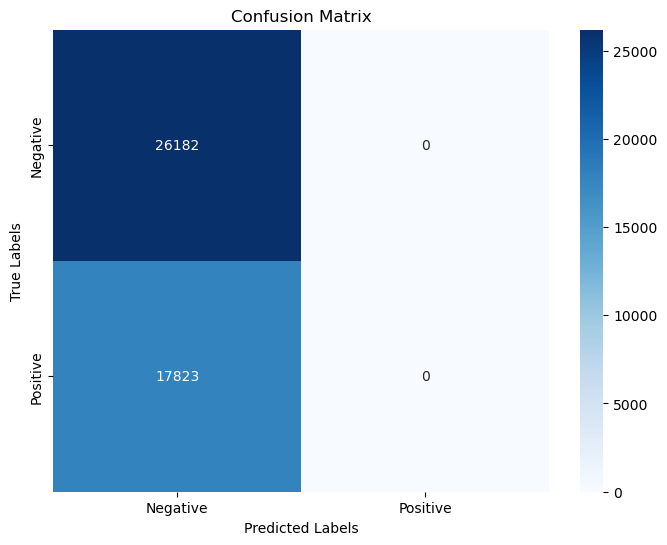

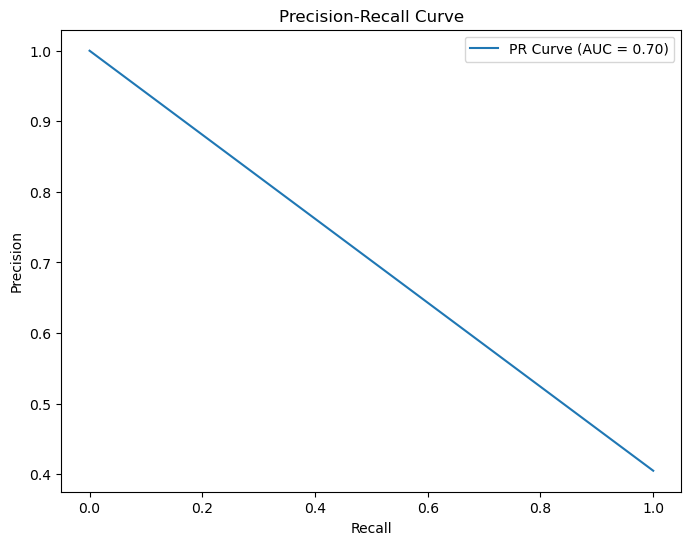

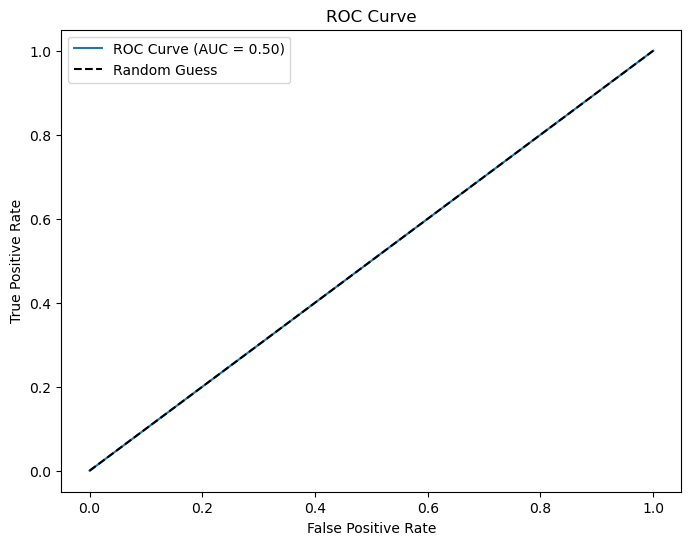

Optimized CNN model saved.


In [41]:
with torch.no_grad():
    for val_batch, val_labels_batch in load_batches("val_normalized_augmented"):
        val_batch = torch.tensor(val_batch, dtype=torch.float32).view(-1, 3, 64, 64).to(device)
        val_labels_batch = np.array(val_labels_batch)
        probabilities = model(val_batch).cpu().numpy().flatten()
        predictions = (probabilities > 0.5).astype(int)
        all_val_labels.extend(val_labels_batch)
        all_val_predictions.extend(predictions)
        all_val_probabilities.extend(probabilities)

# Convert all validation results to numpy arrays for easier processing
all_val_labels = np.array(all_val_labels)
all_val_predictions = np.array(all_val_predictions)
all_val_probabilities = np.array(all_val_probabilities)

# Calculate and print metrics
accuracy = accuracy_score(all_val_labels, all_val_predictions)
print(f"Validation Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(all_val_labels, all_val_predictions, target_names=["Negative", "Positive"]))

# Plot confusion matrix
conf_matrix = confusion_matrix(all_val_labels, all_val_predictions)
print("Confusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(all_val_labels, all_val_probabilities)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(all_val_labels, all_val_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Save the trained model to a file
torch.save(model.state_dict(), "optimized_cnn_model.pth")
print("Optimized CNN model saved.")

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import pickle
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Check if a GPU is available for faster computations, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to load batches of data from saved files
def load_batches(batch_prefix):
    for batch_file in sorted(glob.glob(f"{batch_prefix}_batch_*.pkl")):
        with open(batch_file, "rb") as f:
            batch_data, batch_labels = pickle.load(f)
            yield batch_data, batch_labels

# Define the Enhanced CNN Model
class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# Instantiate the model and send it to the device (GPU or CPU)
model = EnhancedCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
BATCH_SIZE = 64
EPOCHS = 10
early_stop_patience = 3

# Early Stopping Parameters
best_val_accuracy = 0
early_stop_counter = 0

# Training the model
print("Training Enhanced CNN with Batches...")
model.train()
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    epoch_loss = 0
    for train_batch, train_labels_batch in load_batches("train_normalized_augmented"):
        # Normalize and reshape data
        train_batch = train_batch / 255.0
        train_batch = torch.tensor(train_batch, dtype=torch.float32).view(-1, 3, 64, 64).to(device)
        train_labels_batch = torch.tensor(train_labels_batch, dtype=torch.float32).view(-1, 1).to(device)

        # Forward pass, loss calculation, and optimization
        outputs = model(train_batch)
        loss = criterion(outputs, train_labels_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    scheduler.step()
    print(f"Epoch {epoch + 1} completed. Loss: {epoch_loss:.4f}")

    # Evaluate on validation set
    model.eval()
    all_val_labels, all_val_predictions, all_val_probabilities = [], [], []
    with torch.no_grad():
        for val_batch, val_labels_batch in load_batches("val_normalized_augmented"):
            val_batch = val_batch / 255.0
            val_batch = torch.tensor(val_batch, dtype=torch.float32).view(-1, 3, 64, 64).to(device)
            val_labels_batch = np.array(val_labels_batch)

            probabilities = model(val_batch).cpu().numpy().flatten()
            predictions = (probabilities > 0.5).astype(int)
            all_val_labels.extend(val_labels_batch)
            all_val_predictions.extend(predictions)
            all_val_probabilities.extend(probabilities)

    # Calculate validation accuracy
    all_val_labels = np.array(all_val_labels)
    all_val_predictions = np.array(all_val_predictions)
    val_accuracy = accuracy_score(all_val_labels, all_val_predictions)
    print(f"Validation Accuracy: {val_accuracy:.2f}")

    # Early Stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_cnn_model.pth")
        print("Best model saved.")
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

# Load the best model
model.load_state_dict(torch.load("best_cnn_model.pth"))
print(f"Best Validation Accuracy: {best_val_accuracy:.2f}")

# Evaluate the best model on validation data
# (optional evaluation metrics and plots, similar to the earlier code)


Training Enhanced CNN with Batches...
Epoch 1/10
Epoch 1 completed. Loss: 289.8461
Validation Accuracy: 0.41
Best model saved.
Epoch 2/10
Epoch 2 completed. Loss: 41964.0000
Validation Accuracy: 0.41
Epoch 3/10
Epoch 3 completed. Loss: 41964.0000
Validation Accuracy: 0.41
Epoch 4/10
Epoch 4 completed. Loss: 41964.0000


KeyboardInterrupt: 

## 3 Models Comparison

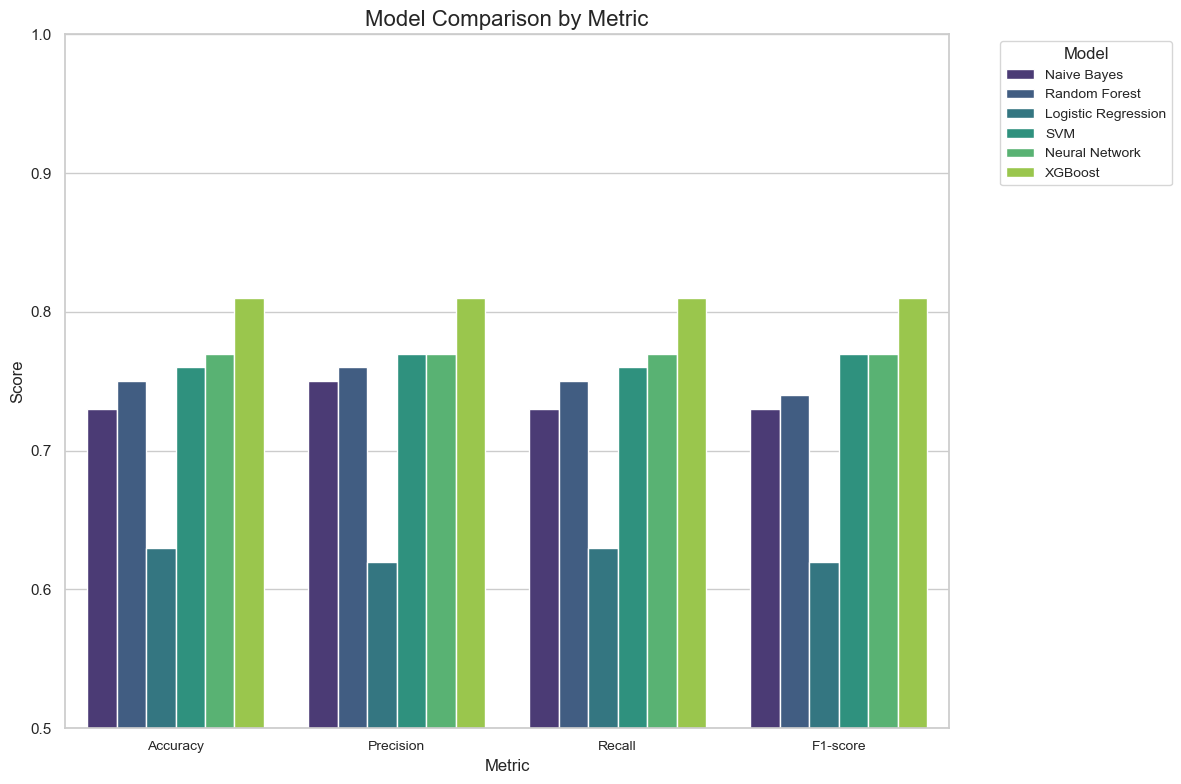

In [23]:
metrics_summary = {
    "Model": [
        "Naive Bayes",
        "Random Forest",
        "Logistic Regression",
        "SVM",
        "Neural Network",
        "XGBoost"
    ],
    "Accuracy": [0.73, 0.75, 0.63, 0.76, 0.77, 0.81],
    "Precision": [0.75, 0.76, 0.62, 0.77, 0.77, 0.81],
    "Recall": [0.73, 0.75, 0.63, 0.76, 0.77, 0.81],
    "F1-score": [0.73, 0.74, 0.62, 0.77, 0.77, 0.81]
}

metrics_df = pd.DataFrame(metrics_summary)
metrics_melted = pd.melt(
    metrics_df,
    id_vars="Model",
    value_vars=["Accuracy", "Precision", "Recall", "F1-score"],
    var_name="Metric",
    value_name="Score"
)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=metrics_melted,
    x="Metric",
    y="Score",
    hue="Model",
    palette="viridis"
)


plt.title("Model Comparison by Metric", fontsize=16)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Metric", fontsize=12)
plt.ylim(0.5, 1.0)  
plt.xticks(fontsize=10)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()

### Future Improvements

1. **Neural Network**
    - Experiment with different loss functions (e.g., focal loss to address class imbalance).
    - Dynamically adjust the learning rate using schedulers.
    - Increase the number of epochs for extended training.

2. **XGBoost**
    - Fine-tune hyperparameters (e.g., tree depth, subsampling rates).
    - Incorporate custom objective functions to better handle class imbalance.


### Real-World Application
 - Cancer is one of the leading causes of death worldwide. Early detection of metastatic cancer through histopathologic analysis can significantly improve treatment outcomes. This project demonstrates how modern AI techniques, particularly neural networks and ensemble methods, can enhance the accuracy and speed of cancer detection. By leveraging technology, we aim to aid medical professionals in making faster and more reliable diagnoses, ultimately contributing to better patient care and outcomes.
 - This work highlights the potential of machine learning to revolutionize healthcare and make a meaningful impact on human lives.



### Contribution of Team Members

1. **Jing Wang:**
    - Responsible for data preprocessing, all model training, combining works of other teammates, comparison, and report writing.

2. **Vikash Bajiya:**
    - Responsible for data preprocessing, model training (Logistic regression & SVM), report writing and presentation preparation.
  
3.  **Deviprasad Saka**
    - Responsible for data preprocessing, model training (Naive Bayes & Random Forest), report writing and presentation preparation.
